<a href="https://colab.research.google.com/github/juampyvillar/TP2SOA/blob/master/Cuaderno_1_Grupo9_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **1-Introducción**








El siguiente ejemplo consiste en enriquecer el numero de tonos de una imagen de modo que podamos ver al mismo tiempo sus tonos medios, sus tonos mas oscuros y sus tonos mas luminosos, reduciendo el contraste global.
Existen diferentes tecnicas que podemos utilizar para realizar el mapeo tonal.  Se puede realizar tecnicas en la camara y en postproduccion. Como realizaremos una edicion en postproduccion realizaremos la tecnica de Reinhard a una imagen que tiene que ser HDR. Cabe destacar que, segun la consigna planteada donde no se puede utilizar OpenCV y evaluando la imposibildad de trabajar con un archivo .hdr en esta plataforma, el algoritmo es implementado en una imagen JPG, donde se realiza la siguiente expresion para el RGB de cada pixel de la imagen:

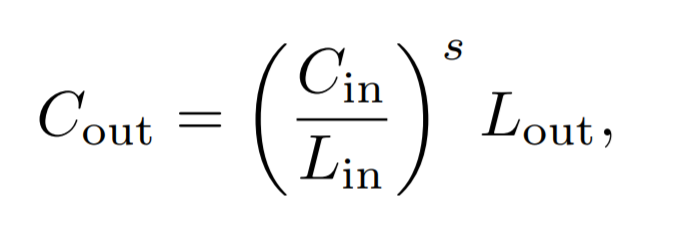

EL objetivo es enseñar el funcionamiento del Lenguaje Python [2] y el manejo de Google Colab [2,3] y las imágenes a bajo nivel. El ejemplo es ilustrativo, ya que internamente el módulo Pillow posee varios filtros integrados.



# **2-Armado del ambiente**



Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

In [ ]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen H:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/juampyvillar/TP2SOA/blob/master/HPC/HDRimagen/memorial.jpg -O imagen.jpg

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen} -O imagen.jpg

--2021-11-25 22:12:02--  https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg [following]
--2021-11-25 22:12:02--  https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg [following]
--2021-11-25 22:12:02--  https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147032 (144K) [image/j

#**2.2 Instala en el cuaderno el módulo CUDA de Python.**

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 4.1 MB/s 
     |████████████████████████████████| 75 kB 3.4 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627577 sha256=3264b3b7d79e37d8ed1a73f42af6cacc9e44eafe1f9bbf6a54bdab0821bc69da
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=298a694800903de3fb564a872c8899fdfe7ec0da58473ef47530c40efa6854c9
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


#**3.1-Desarrollo CPU**

Desarrollo en cpu- Secuencialmente


Imagen del filtro: imagen.jpg -RGB- [1024, 768]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tiempo TOTAL: 19140.002 [ms]
Tiempo de conversión de imagen: 19041.275 [ms]


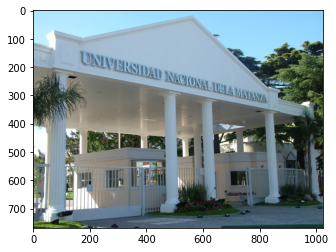

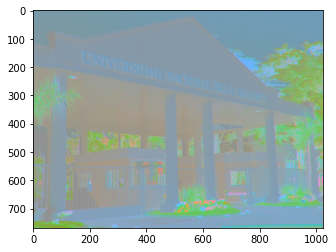

In [ ]:
%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms_cpu = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Obtengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img = datetime.now()

for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
    pixel_R, pixel_G, pixel_B = img_pic_cpu[y][x]
    luminancia= (0.2126 * pixel_R + 0.7152 * pixel_G + 0.0722 * pixel_B)
    nuevaLuminancia= luminancia/(luminancia+1.0) 
    
    pixel_R = (((pixel_R * nuevaLuminancia)**0.9)/luminancia)*255
    pixel_G = (((pixel_G * nuevaLuminancia)**0.9)/luminancia)*255
    pixel_B = (((pixel_B * nuevaLuminancia)**0.9)/luminancia)*255
    
    img_picR_cpu[y][x] = [pixel_R, pixel_G,pixel_B]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo TOTAL:",                   tiempo_en_ms_cpu( tiempo_total ), "[ms]" )
print( "Tiempo de conversión de imagen:", tiempo_en_ms_cpu( tiempo_img   ), "[ms]" )



tiempo_img_cpu=tiempo_en_ms_cpu( tiempo_img   )
tiempo_total_cpu=tiempo_en_ms_cpu( tiempo_total )

#**3.2 Desarrollo GPU**


Desarrollo en GPU - Paralelo


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen del filtro: imagen.jpg -RGB- [1024, 768]
Thread: [ 16 , 19  ], Bloque : [ 64 , 41 ]
Total de Thread: [ 1024 , 779  ]  =  797696
Tiempo TOTAL:  118.49 [ms]
Tiempo de conversion de imagen  :  0.251 [ms]


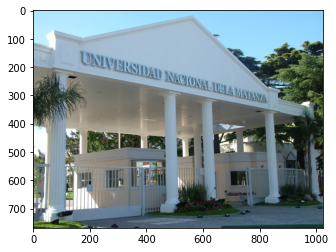

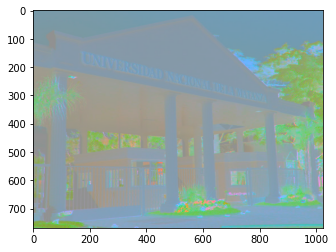

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms_gpu = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float pixel_R, pixel_G, pixel_B, luminancia, nuevaLuminancia;

  if( idx < ancho && idy < alto )
  {
    pixel_R = (float)img_O[(idx+(idy*ancho))*3    ];
    pixel_G = (float)img_O[((idx+(idy*ancho))*3)+1];
    pixel_B = (float)img_O[((idx+(idy*ancho))*3)+2];
    luminancia= (0.2126 * pixel_R + 0.7152 * pixel_G + 0.0722 * pixel_B);
    nuevaLuminancia= luminancia/(luminancia+1.0);
    pixel_R = (std::pow((pixel_R * nuevaLuminancia),0.9)/luminancia)*255;
    pixel_G = (std::pow((pixel_G * nuevaLuminancia),0.9)/luminancia)*255;
    pixel_B = (std::pow((pixel_B * nuevaLuminancia),0.9)/luminancia)*255;

    img_R[(idx+(idy*ancho))*3  ] = (int) pixel_R;
    img_R[(idx+(idy*ancho))*3+1] = (int) pixel_G;
    img_R[(idx+(idy*ancho))*3+2] = (int) pixel_B;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms_gpu( tiempo_total ), "[ms]" )
print("Tiempo de conversion de imagen  : ", tiempo_en_ms_gpu( tiempo_img ), "[ms]" )

tiempo_img_gpu=tiempo_en_ms_gpu( tiempo_total )
tiempo_total_gpu=tiempo_en_ms_gpu( tiempo_img )


# 4-Metricas

In [ ]:


#Metricas CPU

print( "Tiempo TOTAL CPU:",                   tiempo_total_cpu, "[ms]" )
print( "Tiempo de conversión de imagen: CPU", tiempo_img_cpu, "[ms]" )


# Metricas GPU

print("Tiempo TOTAL GPU: ", tiempo_total_gpu, "[ms]" )
print("Tiempo de conversion de imagen GPU : ", tiempo_img_gpu, "[ms]" )





Tiempo TOTAL CPU: 19015.941 [ms]
Tiempo de conversión de imagen: CPU 18916.697 [ms]
Tiempo TOTAL GPU:  0.251 [ms]
Tiempo de conversion de imagen GPU :  118.49 [ms]


# 5-Conclusion

En conclusion, este ejercicio nos permitio trabajar con una imagen y ver como se modifican los pixeles de la misma, cambiando los valores RGB y viendo los resultados obtenidos en las diferentes pruebas.

Tambien nos permitio ver y evidenciar la gran diferencia de poder de procesamiento entre GPU y CPU, los cuales difieren considerablemente en los tiempos de ejecucion, siendo el de GPU muchisimo mas rapido que su competidor. 

# 6-Bibliografia

[1] https://github.com/Vedant2311/Tone-Mapping-Library/blob/master/Reinhard.m

[2] https://riull.ull.es/xmlui/bitstream/handle/915/7473/ALTO%20RANGO%20DINAMICO%20MEDIANTE%20COMPOSICION%20DE%20IMAGENES.pdf?sequence=1
 
[3] https://programmerclick.com/article/88641737689/

[4] https://64.github.io/tonemapping/

[5] http://szeliski.org/Book/drafts/SzeliskiBook_20100903_draft.pdf